In [1]:
# Goal: Convert the 7774-mangle model to use a GP kernel..
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import numba
import pandas as pd
import george
from george import kernels
import george.modeling as gmodel
from george.utils import multivariate_gaussian_samples

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

egauss = np.vectorize(gaussian.elongated_gaussian)

In [2]:
# extract the base spectrum
sds = specds.load_dataset('SN2019odp')
spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']

In [3]:
# generation function that generates the 63xx profile
C_KM_S = aconst.c.to(u.km/u.s).value
def generation_func_63xx(amp_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum, wave_7774, flux_7774, wave_63xx):
    """
    Generate the 63xx feature.
    flux_7774 should already be continuum subtracted and total flux normalized to 1.0 (@6300)
    """
    
    # get projecting into the velocity space
    center_wave = 7774
    velocity = (wave_7774 - center_wave)/center_wave * C_KM_S
    
    # generate the matching wavelength grids for the velocities
    center_wave = 6300
    wave_6300 = velocity/C_KM_S * center_wave + center_wave
    center_wave = 6364
    wave_6364 = velocity/C_KM_S * center_wave + center_wave
    
    # re-project the 7774 flux onto the observed wavelength grid
    flux_6300 = np.interp(wave_63xx, wave_6300, flux_7774)*amp_6300
    flux_6364 = np.interp(wave_63xx, wave_6364, flux_7774)*amp_6300*ratio_6364
    
    # generate the continuum
    flux_cont = egauss(wave_63xx, 6300, outer_shell_amplitude, outer_shell_line_width, outer_shell_width) + egauss(wave_63xx, 6364, outer_shell_amplitude/3, outer_shell_line_width, outer_shell_width)
    
    flux = flux_6300 + flux_6364 + flux_cont + continuum
    return flux

def generation_func_5577(amp_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum, wave_7774, flux_7774, wave_5577):
    """
    Generate the 5577 feature.
    flux_7774 should already be continuum subtracted and total flux normalized to 1.0 (@6300)
    """
    
    # get projecting into the velocity space
    center_wave = 7774
    velocity = (wave_7774 - center_wave)/center_wave * C_KM_S
    
    # generate the matching wavelength grids for the velocities
    center_wave = 5577
    wave_5577_old = velocity/C_KM_S * center_wave + center_wave
    
    # re-project the 7774 flux onto the observed wavelength grid
    flux_5577 = np.interp(wave_5577, wave_5577_old, flux_7774)*amp_6300*ratio_5577
    
    # generate the outer shell continuum thingy
    flux_cont = egauss(wave_5577, 5577, outer_shell_amplitude * ratio_5577, outer_shell_line_width, outer_shell_width)
    
    flux = flux_5577 + flux_cont + continuum
    return flux

# function to pre-compute the 7774 flux
def premangle_7774_flux(spec, wave7774_min=7550, wave7774_max=8000, wave63xx_min=6050, wave63xx_max=6500):
    idx = np.logical_and(spec['restwave'] > wave7774_min, spec['restwave'] < wave7774_max)
    # remove those annyoing NaN
    idx = np.logical_and(idx, ~np.isnan(spec['flux']))
    wave = spec['restwave'][idx]
    flux = spec['flux'][idx]
    
    # create continuum subtracted flux
    flux_nocont = flux - np.nanpercentile(flux, 1)
    
    # reproject onto 6300 grid
    center_wave = 7774
    velocity = (wave - center_wave)/center_wave * C_KM_S

    #wave_grid = np.arange(6000, 6600, np.median(np.diff(wave))/2)
    idx = np.logical_and(spec['restwave'] > wave63xx_min, spec['restwave'] < wave63xx_max)
    # remove those annyoing NaN
    idx = np.logical_and(idx, ~np.isnan(spec['flux']))
    wave_grid = spec['restwave'][idx]
    
    center_wave = 6300
    wave_6300 = velocity/C_KM_S * center_wave + center_wave
    
    flux_6300 = np.interp(wave_grid, wave_6300, flux_nocont)
    
    # now calculate the flux of the reprojected line
    flux_int = np.trapz(flux_6300, wave_grid)
    #flux_oth = np.trapz(flux_nocont, wave_6300)
    #print(flux_int, flux_oth)
    
    # we want to normalize it 1.0
    norm_factor = 1.0/flux_int
    
    return wave, flux_nocont*norm_factor

In [50]:
@numba.njit
def prior(u, min_continuum, max_continuum, max_line_amp, dwlen, spec_var):
    p = np.empty_like(u)
    
    # 6300 log amplitude
    p[0] = np.log(max_line_amp) - 20*u[0]
    
    # 6364/6300 ratio
    p[1] = 1/(1+2*u[1])
    
    # 5577/6300 ratio
    p[2] = np.exp(-5*u[2])
    
    # outer shell width
    p[3] = 150 + 150*u[3]
    
    # outer shell line width
    p[4] = 50*u[4]
    
    # log outer shell amplitude
    p[5] = np.log(max_line_amp/10) - 20*u[5]
    
    # continuum 63xx
    #p[6] = np.log(max_continuum) - 10*u[6]
    p[6] = (max_continuum-min_continuum)*u[6]+min_continuum
    
    # continuum 5577
    #p[7] = np.log(max_continuum) - 10*u[7]
    p[7] = (max_continuum-min_continuum)*u[7]+min_continuum
    
    # GP white noise
    #p[8] = np.log(2*spec_std**2) - 10*u[8]
    
    # GP kernel amplitude
    p[8] = np.log(spec_var) - 10*u[8]
    
    # GP log scale
    p[9] = np.log(dwlen*(2+4*u[9]))
    
    return p

def gp_logl(gp, model_flux, obs_flux):
    gp.recompute()
    mu = model_flux
    y = obs_flux
    r = np.ascontiguousarray(
        gp._check_dimensions(y) - mu, dtype=np.float64
    )
    ll = gp._const - 0.5 * gp.solver.dot_solve(r)
    return ll if np.isfinite(ll) else -np.inf

def likelihood(p, wave_7774, flux_7774, wave_63xx, flux_63xx, wave_5577, flux_5577, gp_5577, gp_63xx):
    amp_6300 = np.exp(p[0])
    ratio_6364 = p[1]
    ratio_5577 = p[2]
    outer_shell_width = p[3]
    outer_shell_line_width = p[4]
    outer_shell_amplitude = np.exp(p[5])
    continuum_63xx = p[6]
    continuum_5577 = p[7]
    
    model_flux_63xx = generation_func_63xx(amp_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_63xx, wave_7774, flux_7774, wave_63xx)
    
    model_flux_5577 = generation_func_5577(amp_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_5577, wave_7774, flux_7774, wave_5577)
    
    gp_5577.set_parameter_vector(p[8:])
    gp_63xx.set_parameter_vector(p[8:])
    
    logl_5577 = gp_logl(gp_5577, model_flux_5577, flux_5577)
    logl_63xx = gp_logl(gp_63xx, model_flux_63xx, flux_63xx)
    
    #logl_63xx = -0.5*np.sum( (model_flux_63xx*scale_factor - flux_63xx*scale_factor)**2 )
    
    #logl_5577 = -0.5*np.sum( (model_flux_5577*scale_factor - flux_5577*scale_factor)**2 )
    #print(f'5577={logl_5577} 63xx={logl_63xx}')
    return logl_63xx+logl_5577

def render_func(p, wave_7774, flux_7774, wave_63xx, wave_5577):
    amp_6300 = np.exp(p[0])
    ratio_6364 = p[1]
    ratio_5577 = p[2]
    outer_shell_width = p[3]
    outer_shell_line_width = p[4]
    outer_shell_amplitude = np.exp(p[5])
    continuum_63xx = p[6]
    continuum_5577 = p[7]
    
    model_flux_63xx = generation_func_63xx(amp_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_63xx, wave_7774, flux_7774, wave_63xx)
    
    model_flux_5577 = generation_func_5577(amp_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_5577, wave_7774, flux_7774, wave_5577)
    
    return model_flux_63xx, model_flux_5577

def extract_region(spec, wave_min, wave_max):
    idx = np.logical_and(spec['restwave'] > wave_min, spec['restwave'] < wave_max)
    # remove those annyoing NaN
    idx = np.logical_and(idx, ~np.isnan(spec['flux']))
    wave = spec['restwave'][idx]
    flux = spec['flux'][idx]
    
    return wave, flux

def run_fit(spec, regions={}, dynesty_method='unif', dynesty_pfrac=0.5, nlive_init=3000):
    wave_7774, flux_7774 = premangle_7774_flux(spec, wave7774_min=regions['7774_min'], wave7774_max=regions['7774_max'], wave63xx_min=regions['63xx_min'], wave63xx_max=regions['63xx_max'])
    
    # extract the 63xx region
    wave_63xx, flux_63xx = extract_region(spec, regions['63xx_min'], regions['63xx_max'])
    
    # extract the 5577 region
    wave_5577, flux_5577 = extract_region(spec, regions['5577_min'], regions['5577_max'])
    
    # for now fixed configured scale factor
    #scale_factor = np.sqrt(2)/7.002413899090286e-18
    scale_factor = 1/7.002413899090286e-18
    std = 1/scale_factor
    dwlen = np.diff(spec['restwave']).mean()
    spec_var = np.nanvar(np.diff(spec['flux']))
    print(spec_var)
    
    gp_5577 = george.GP(1 * kernels.ExpSquaredKernel(1), mean=np.mean(flux_5577), fit_mean=False)
    gp_63xx = george.GP(1 * kernels.ExpSquaredKernel(1), mean=np.mean(flux_63xx), fit_mean=False) 
    #print(gp_5577.get_parameter_vector())
    print(gp_5577.get_parameter_names())
    gp_5577.compute(wave_5577, yerr=std)
    gp_63xx.compute(wave_63xx, yerr=std)
    
    prior_args = (np.nanpercentile(spec['flux'], 1), 2*np.nanpercentile(spec['flux'], 40), np.nanpercentile(spec['flux'], 95)*1e6, dwlen, spec_var)
    
    logl_args = (wave_7774, flux_7774, wave_63xx, flux_63xx, wave_5577, flux_5577, gp_5577, gp_63xx)
    
    ndim = 10
    
    sampler = dynesty.DynamicNestedSampler(likelihood, prior, ndim,
                                           logl_args=logl_args,
                                           nlive=8000,
                                           ptform_args=prior_args,
                                           method=dynesty_method,
                                           slices=7,
                                           enlarge=3,
                                           walks=50)
    sampler.run_nested(nlive_init=nlive_init, wt_kwargs={'pfrac': dynesty_pfrac}, dlogz_init=1)
    results = sampler.results
    
    samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights)
    #if not quiet:
    print('\tMean: %s' % repr(mean))
    print('\n\t\t'.join(('\tCov: %s' % repr(cov)).split('\n')))

    new_samples = dyfunc.resample_equal(samples, weights)
    
    return sampler, new_samples

In [51]:
regions = {
    '7774_min': 7550,
    '7774_max': 8000,
    '63xx_min': 6100,
    '63xx_max': 6540,
    '5577_min': 5400,
    '5577_max': 5650
}

sampler, trace = run_fit(spec, regions)

0it [00:00, ?it/s]

1.8550056445598978e-34
('kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0')


447it [00:28, 64.66it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 483 | eff(%): 12.834 | loglstar:   -inf < 6763.265 <    inf | logz: 6761.286 +/-  0.036 | dlogz:  1.981 >  1.000]Traceback (most recent call last):
  File "/home/welterde/.local/lib/python3.8/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-50-001d0eed043c>", line 70, in likelihood
    logl_63xx = gp_logl(gp_63xx, model_flux_63xx, flux_63xx)
  File "<ipython-input-50-001d0eed043c>", line 43, in gp_logl
    gp.recompute()
  File "/home/welterde/.local/lib/python3.8/site-packages/george/gp.py", line 332, in recompute
    self.compute(self._x, np.sqrt(self._yerr2), **kwargs)
  File "/home/welterde/.local/lib/python3.8/site-packages/george/gp.py", line 309, in compute
    self.solver.compute(self._x, yerr, **kwargs)
  File "/home/welterde/.local/lib/python3.8/site-packages/george/solvers/basic.py", line 68, in compute
    self._factor = (cholesky(K

Exception while calling loglikelihood function:
  params: [-4.04251356e+01  4.74713711e-01  4.44729663e-01  2.71214616e+02
  2.52819493e+01 -3.96507032e+01  9.48064525e-17  3.10235968e-17
 -8.67029564e+01  1.88068612e+00]
  args: (<Column name='restwave' dtype='float64' length=374>
 7550.83043082635
 7552.00980329333
7553.188682835264
7554.368055302247
7555.547427769227
7556.726307311163
7557.905679778143
7559.085052245126
 7560.26393178706
7561.443304254041
7562.622578136013
7563.801950602995
              ...
7985.839643595474
 7987.02433965296
7988.209035710447
7989.393633182925
7990.578329240412
7991.763025297899
7992.948115695423
 7994.13281175291
7995.317409225388
7996.502105282874
7997.687195680399
7998.871891737886, <Column name='flux' dtype='float64' length=374>
0.00010895574200884993
0.00017901506499093937
0.00025432761962741653
 0.0007517942935412982
 0.0003233673539661781
 0.0005116286897830428
0.00011893646895417309
 0.0007582234173183168
 0.0006508105612223408
  0.0005101

KeyboardInterrupt: 

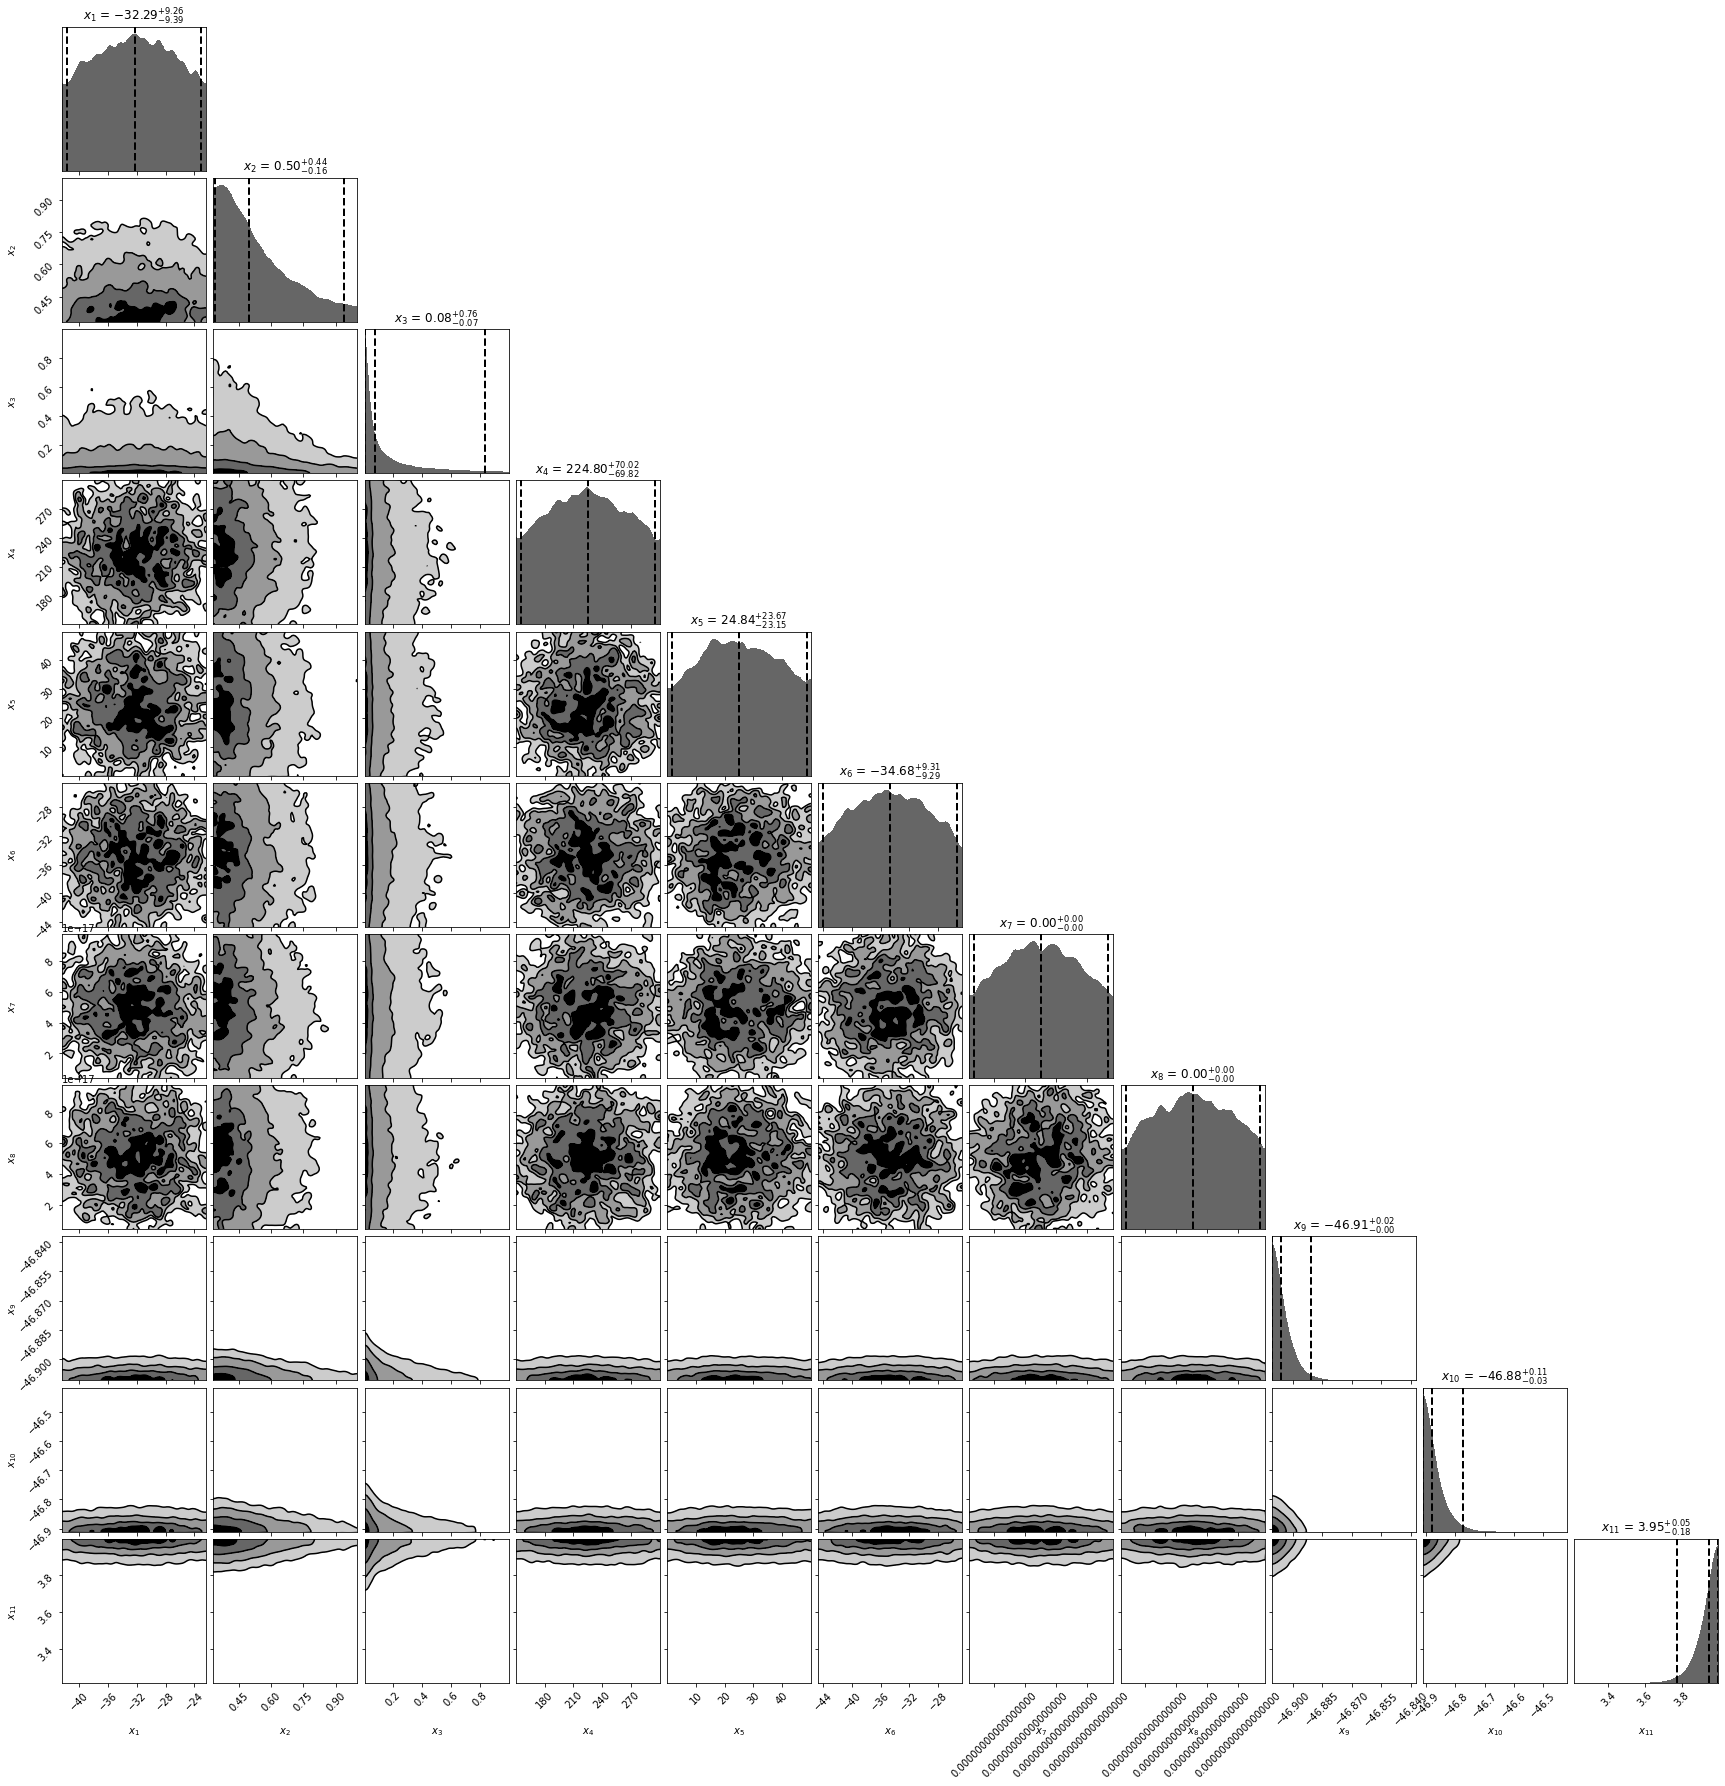

In [11]:
dyplot.cornerplot(sampler.results, show_titles=True);


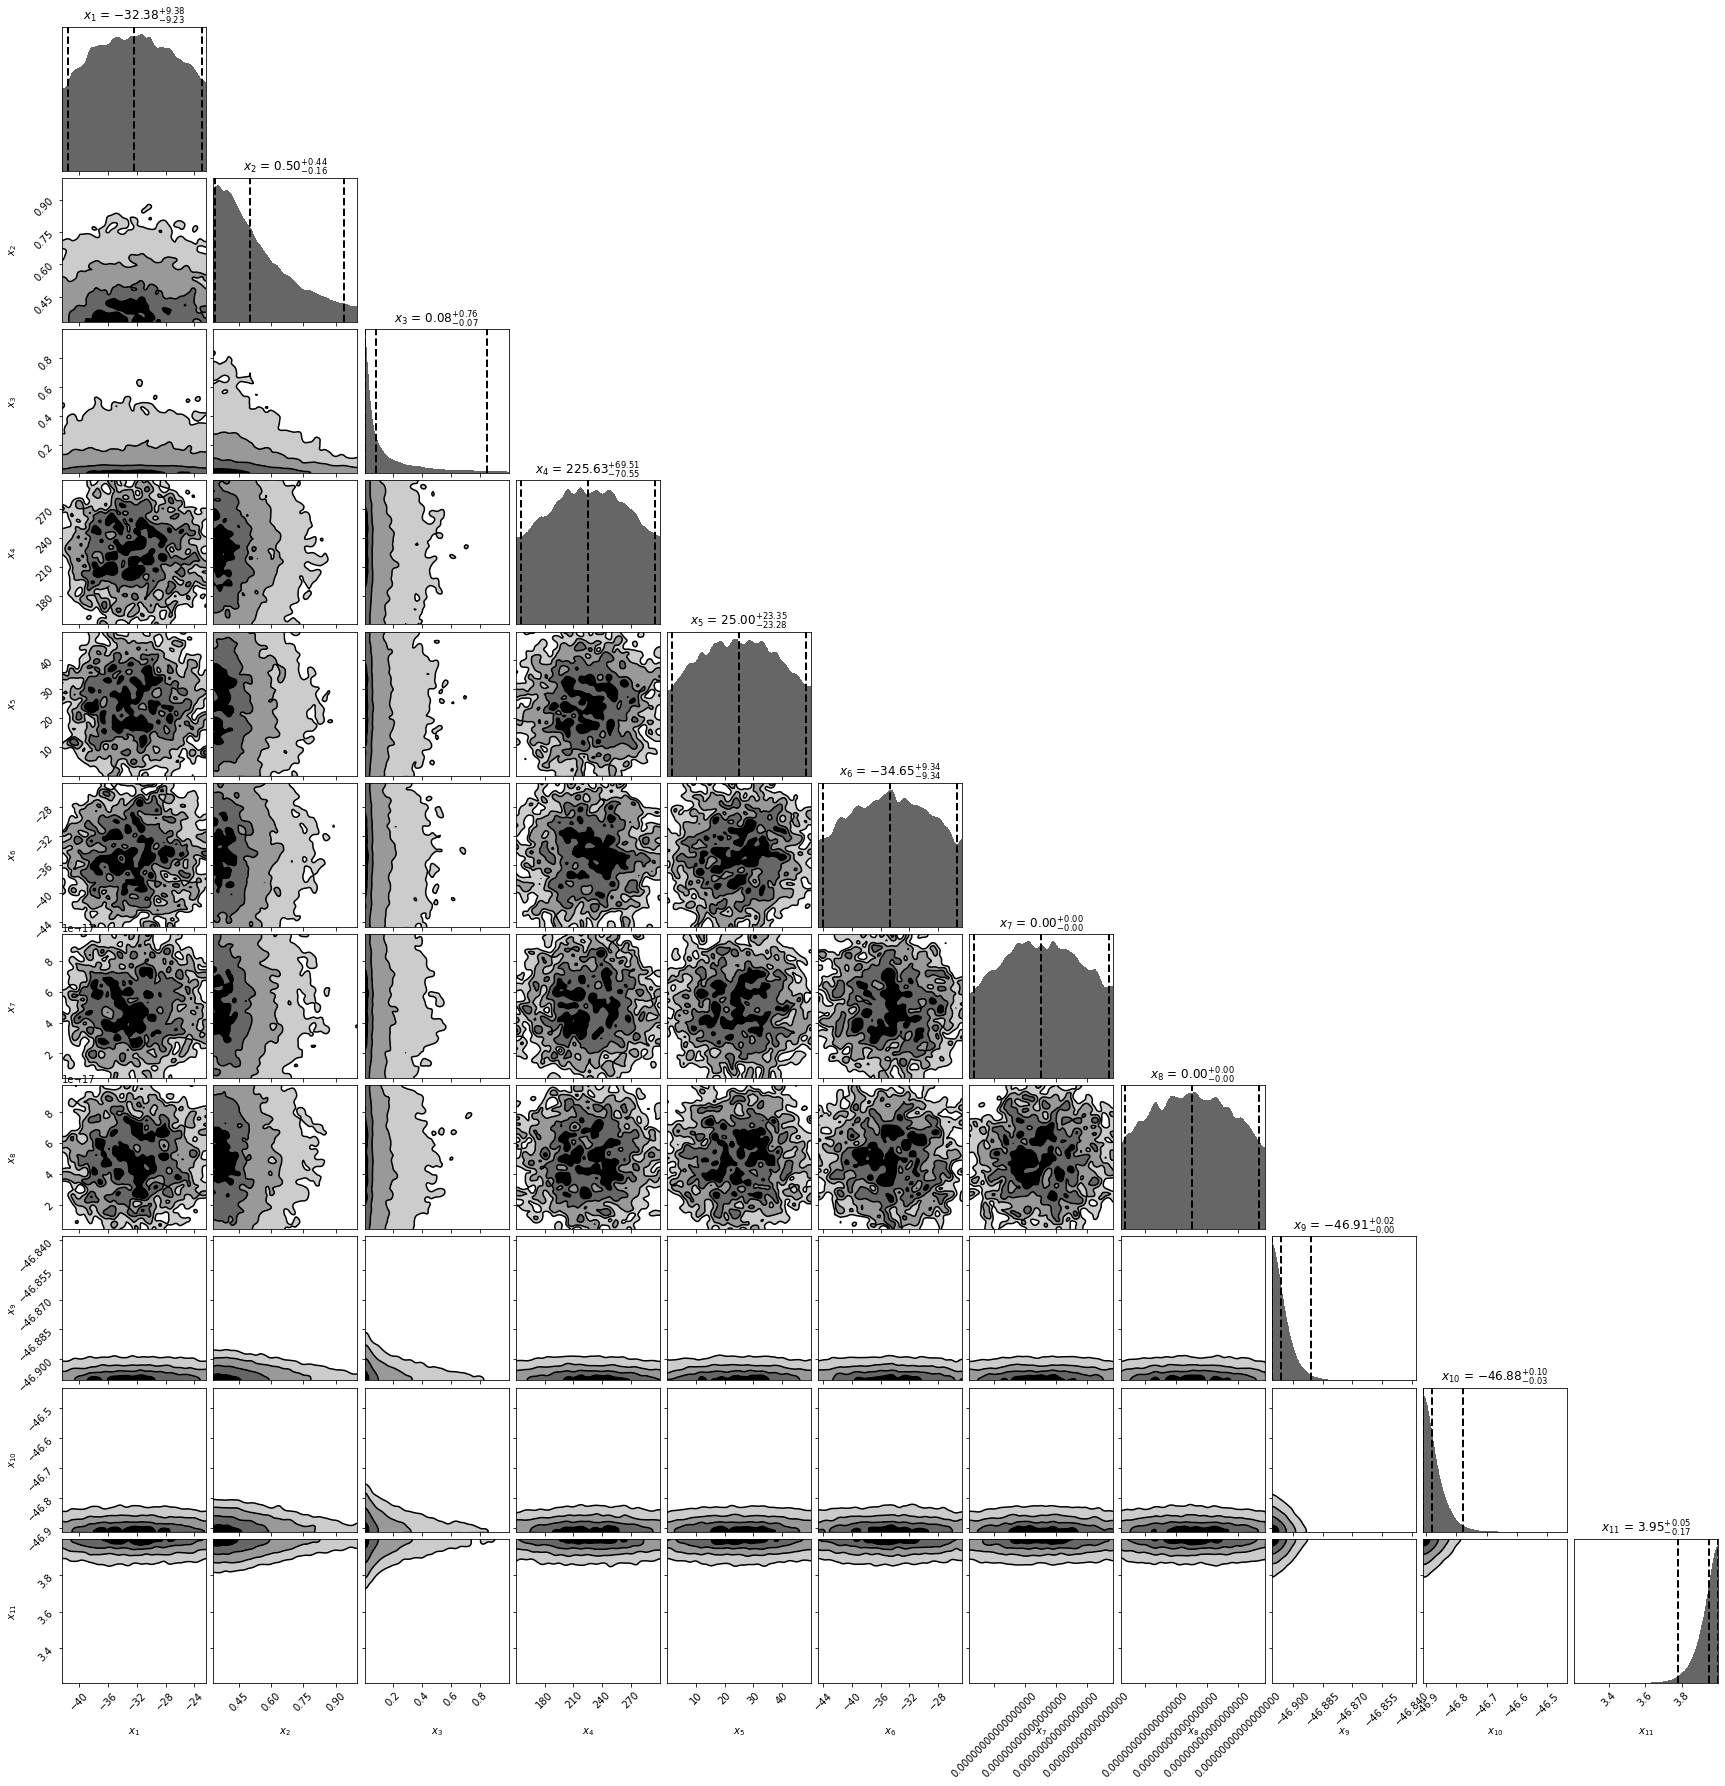

In [16]:
dyplot.cornerplot(sampler2.results, show_titles=True);

In [12]:
def render_func(p, wave_7774, flux_7774, wave_63xx, wave_5577):
    amp_6300 = np.exp(p[0])
    ratio_6364 = p[1]
    ratio_5577 = p[2]
    outer_shell_width = p[3]
    outer_shell_line_width = p[4]
    outer_shell_amplitude = np.exp(p[5])
    continuum_63xx = p[6]
    continuum_5577 = p[7]
    
    model_flux_63xx = generation_func_63xx(amp_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_63xx, wave_7774, flux_7774, wave_63xx)
    
    model_flux_5577 = generation_func_5577(amp_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_5577, wave_7774, flux_7774, wave_5577)
    
    return model_flux_63xx, model_flux_5577

def show(spec, regions, trace, ax_5577, ax_63xx, num_samples=1000):
    wave_7774, flux_7774 = premangle_7774_flux(spec, wave7774_min=regions['7774_min'], wave7774_max=regions['7774_max'], wave63xx_min=regions['63xx_min'], wave63xx_max=regions['63xx_max'])
    
    # extract the 63xx region
    wave_63xx, flux_63xx = extract_region(spec, regions['63xx_min'], regions['63xx_max'])
    
    # extract the 5577 region
    wave_5577, flux_5577 = extract_region(spec, regions['5577_min'], regions['5577_max'])
    
    ax_5577.plot(wave_5577, flux_5577, label='Spec', color='red')
    ax_63xx.plot(wave_63xx, flux_63xx, label='Spec', color='red')
    
    for idx in np.random.randint(trace.shape[0], size=num_samples):
        p = trace[idx]
        flux_63xx, flux_5577 = render_func(p, wave_7774, flux_7774, wave_63xx, wave_5577)
        ax_5577.plot(wave_5577, flux_5577, color='grey', alpha=0.05, lw=1)
        ax_63xx.plot(wave_63xx, flux_63xx, color='grey', alpha=0.05, lw=1)

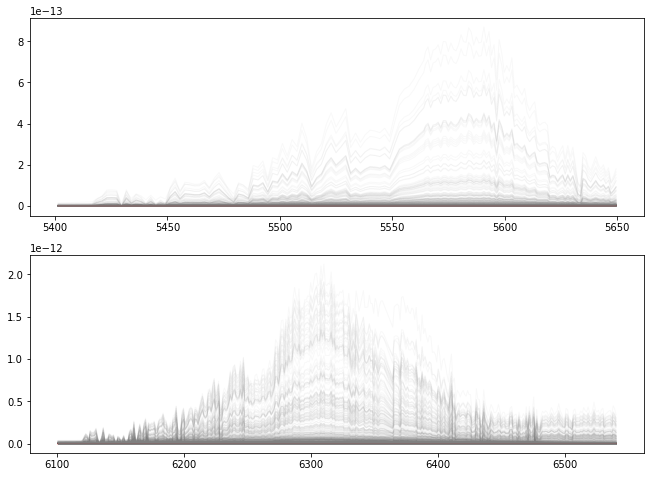

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show(spec, regions, trace, ax1, ax2)

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show(spec, regions, trace2, ax1, ax2)

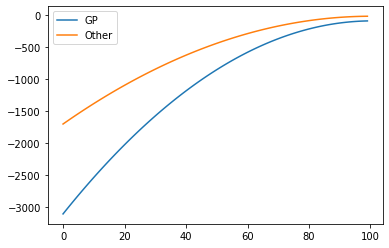

In [54]:
# unrelated tests of the GP stuff
data = np.linspace(0, 10, num=100) + np.random.normal(0, 0.5, size=100)
#plt.plot(data)
gp = george.GP(0.01 * kernels.ExpSquaredKernel(1), mean=0, fit_mean=False)
gp.compute(np.linspace(0, 1, num=100), yerr=0.4)

logl = np.empty(100)
for i in range(100):
    mod = np.linspace(0, i/10, num=100)
    logl[i] = gp_logl(gp, mod, data)
plt.plot(logl, label='GP')

logl = np.empty(100)
for i in range(100):
    mod = np.linspace(0, i/10, num=100)
    logl[i] = -0.5 * np.sum( (data-mod)**2)
plt.plot(logl, label='Other')
plt.legend()

In [55]:
spec

<Table length=5122>
   col1       col2         col3    ... fluxerr mask      restwave     
 float64    float64      float64   ... float64 bool      float64      
--------- ------------ ----------- ... ------- ---- ------------------
3077.8789  5.06267e-17 1.75022e-16 ...     nan True 3034.3272016743676
3079.8264 -7.97656e-17 1.31711e-16 ...     nan True  3036.247144731666
3081.7744  5.95832e-17 2.12345e-16 ...     nan True 3038.1675807140114
3083.7229  7.42197e-17 1.93656e-16 ...     nan True 3040.0885096214042
3085.6721  1.15375e-16 2.35723e-16 ...     nan True 3042.0101286238614
3087.6218 -2.18573e-17 1.77419e-16 ...     nan True  3043.932240551366
3089.5723 -1.14554e-17 1.21939e-16 ...     nan True  3045.855141158945
3091.5232 -1.51394e-17 1.24748e-16 ...     nan True 3047.7784361065624
3093.4749  4.60466e-17  1.8944e-16 ...     nan True  3049.702519734254
 3095.427  1.31466e-16 1.00609e-16 ...     nan True 3051.6269977019833
      ...          ...         ... ...     ...  ...                ...
10292.792 -3.76546e-18 2.73147e-15 ...     nan True 10147.149956671887
10294.005  5.27492e-17 1.33986e-15 ...     nan True 10148.345792835431
10295.218  7.28596e-18  1.0816e-15 ...     nan True 10149.541628998977
10296.431  7.05009e-17 1.33975e-15 ...     nan True 10150.737465162521
10297.643  6.40906e-17  1.5862e-15 ...     nan True 10151.932315475973
10298.856  7.86695e-17 1.74478e-15 ...     nan True 10153.128151639517
 10300.07  1.32219e-17 1.55397e-15 ...     nan True 10154.324973653156
10301.283  2.42695e-17 1.11505e-15 ...     nan True   10155.5208098167
10302.496  3.57299e-17 7.51526e-16 ...     nan True 10156.716645980245
 10303.71  3.80395e-18 5.44402e-16 ...     nan True 10157.913467993882